In this second practical session, we will use `gudhi` to compute persistence diagrams of standard filtrations. We will first start with synthetic and intuitive examples, and then apply persistence on point clouds obtained from time series using time-delay embeddings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm
import gudhi as gd

In [2]:
%matplotlib notebook

## 1.  Persistence Diagrams of standard spaces

### 1. Functions, cubical complex

#### Volcano

Let us first define a function from $\mathbb{R}^2 \to \mathbb{R}$.

<IPython.core.display.Javascript object>


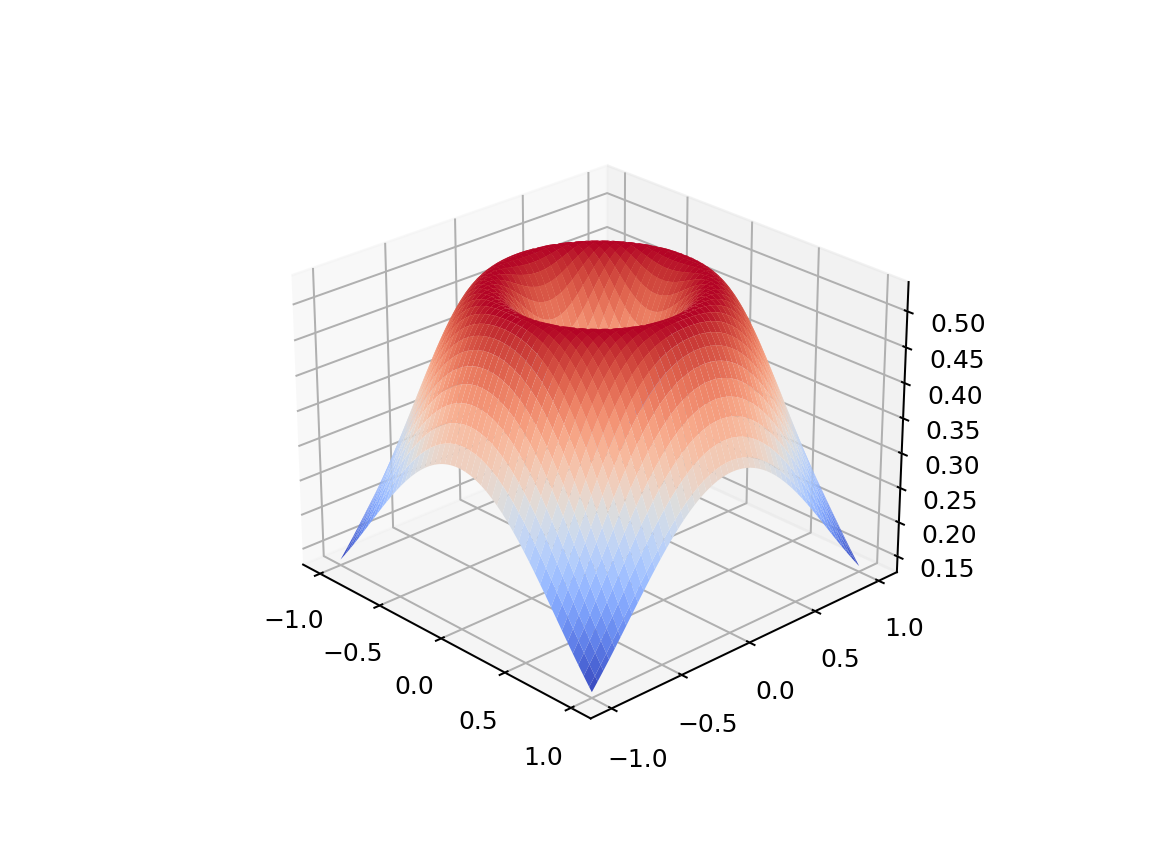

In [3]:
grid = np.linspace(-1,1,100)
gridx = grid[:,np.newaxis]
gridy = grid[np.newaxis,:]
sq = - gridx**2 - gridy**2
volcano = np.exp(sq) - 0.7 * np.exp(sq*4)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(gridx, gridy, volcano, cmap=matplotlib.cm.coolwarm)
plt.show()

Now that we have a function, build a filtered [cubical complex](https://gudhi.inria.fr/python/latest/cubical_complex_ref.html) from it and compute the persistence diagram of its **sub**levelsets. You should obtain the plots below.

<IPython.core.display.Javascript object>


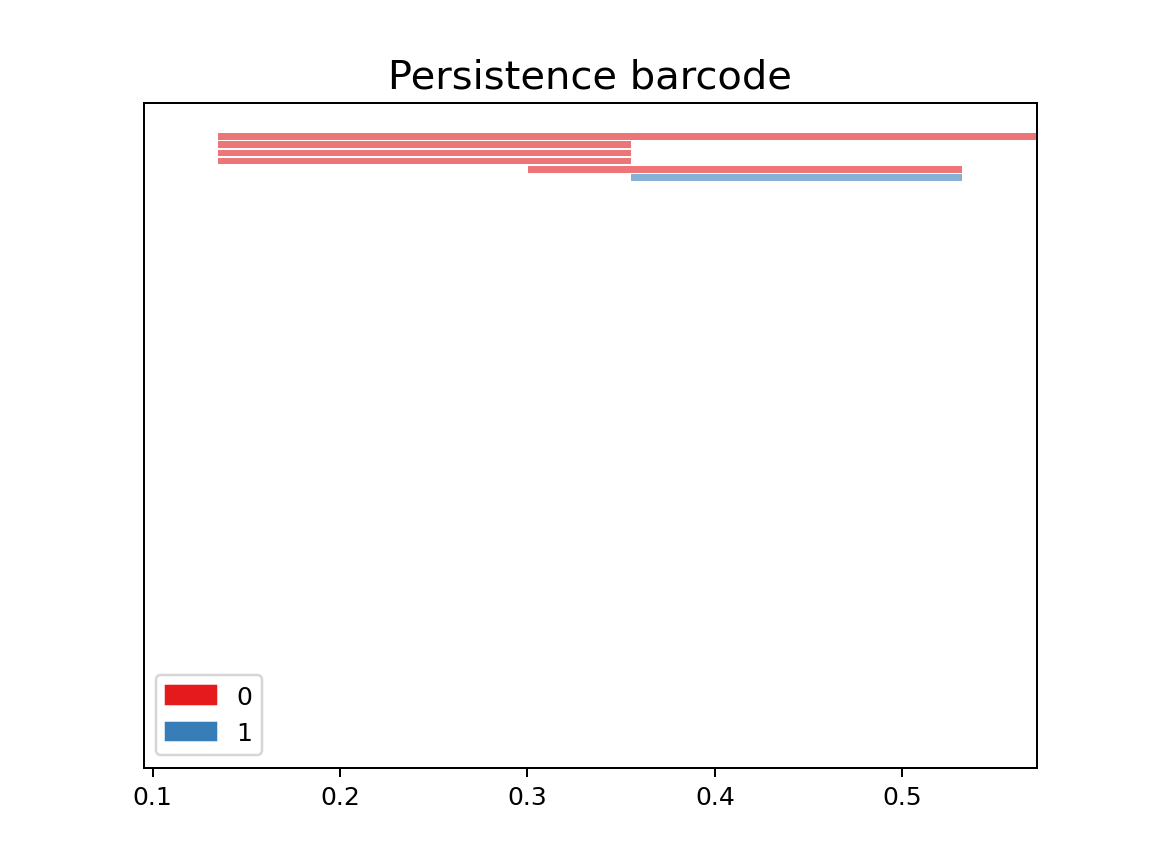

<IPython.core.display.Javascript object>


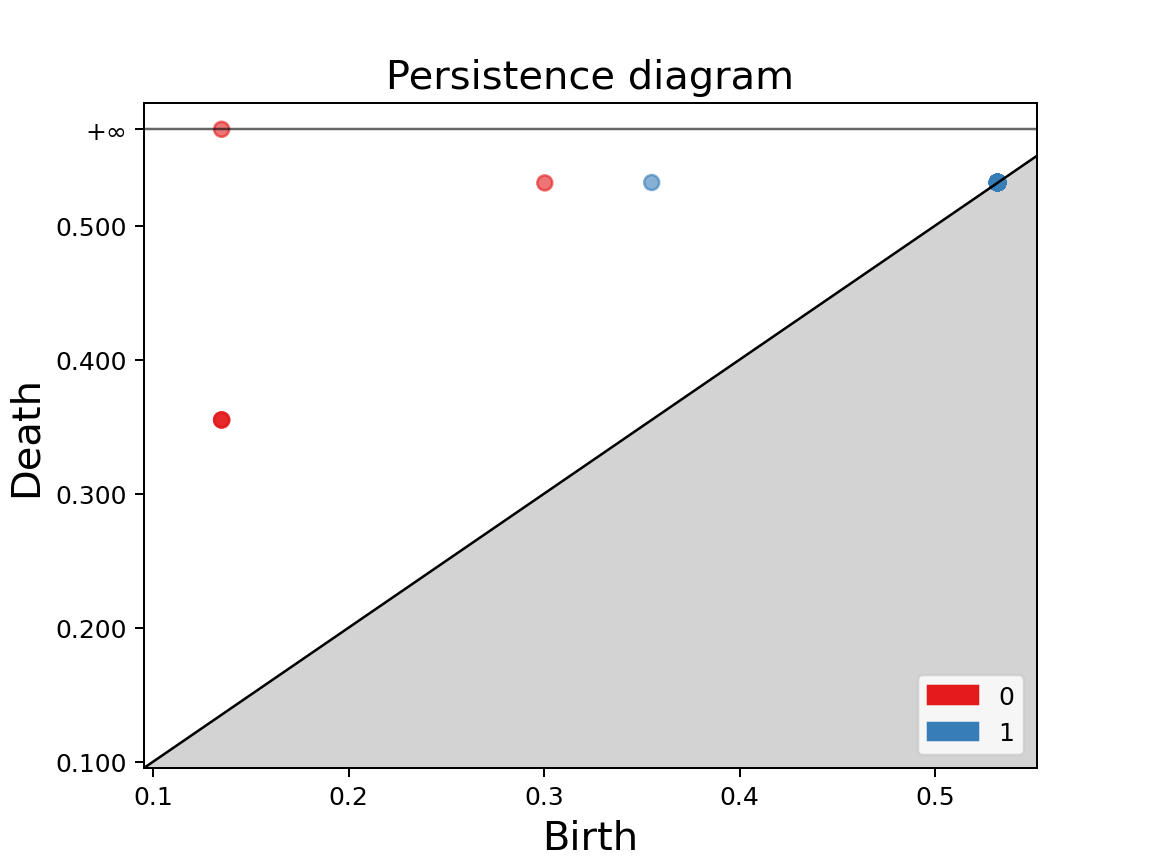

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

In [11]:
cplx = gd.CubicalComplex(top_dimensional_cells = volcano)
diag = cplx.persistence()
gd.plot_persistence_barcode(diag, legend=True)
gd.plot_persistence_diagram(diag, legend=True)

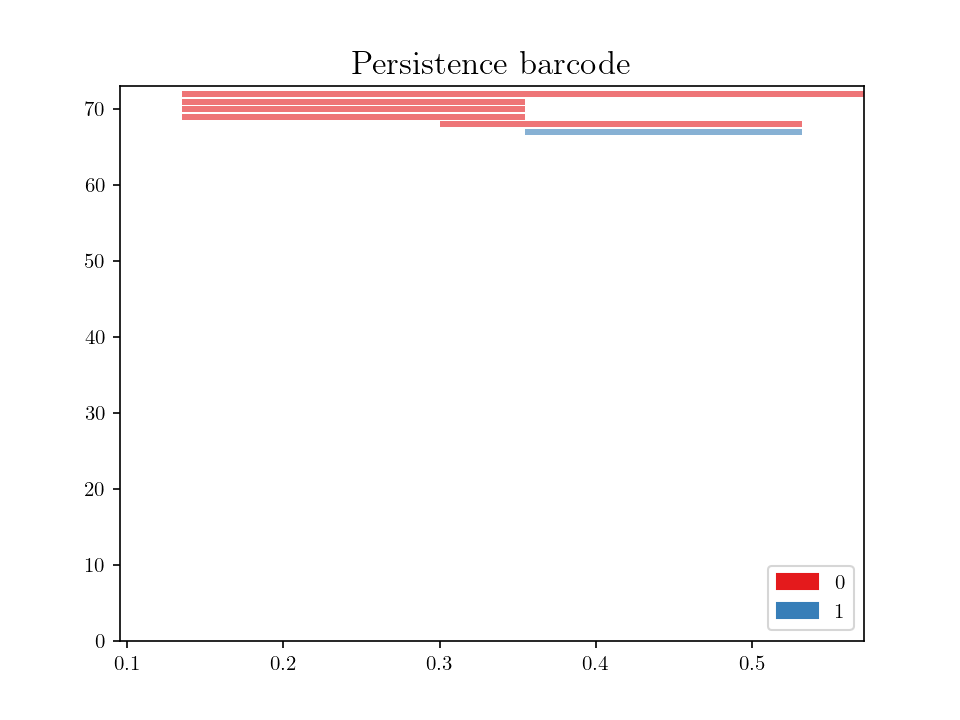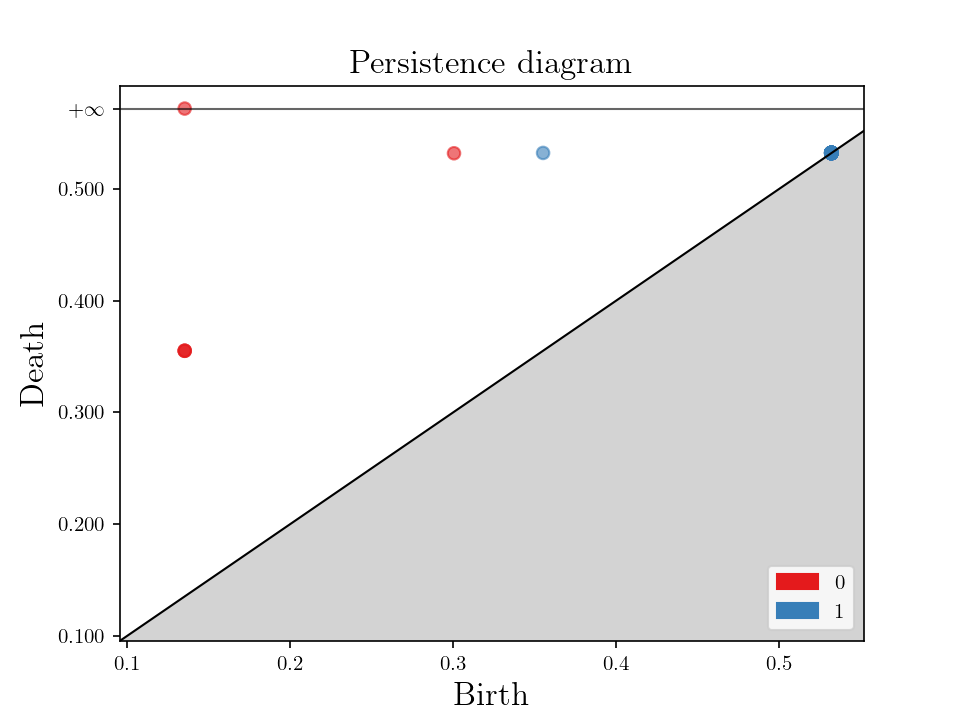

Compare the 2 plots. Why do we only see 3 red points but 5 red bars? Why are more than 60 of the bars invisible? You can print `diag` to help, the format is a list of `(dimension, (birth, death))`.

In [8]:
len(diag)

73

Now compute the persistence diagram of the **super**levelsets of this function (hint: there is no direct function to that, only sublevelsets). You should obtain the plots below.

<IPython.core.display.Javascript object>


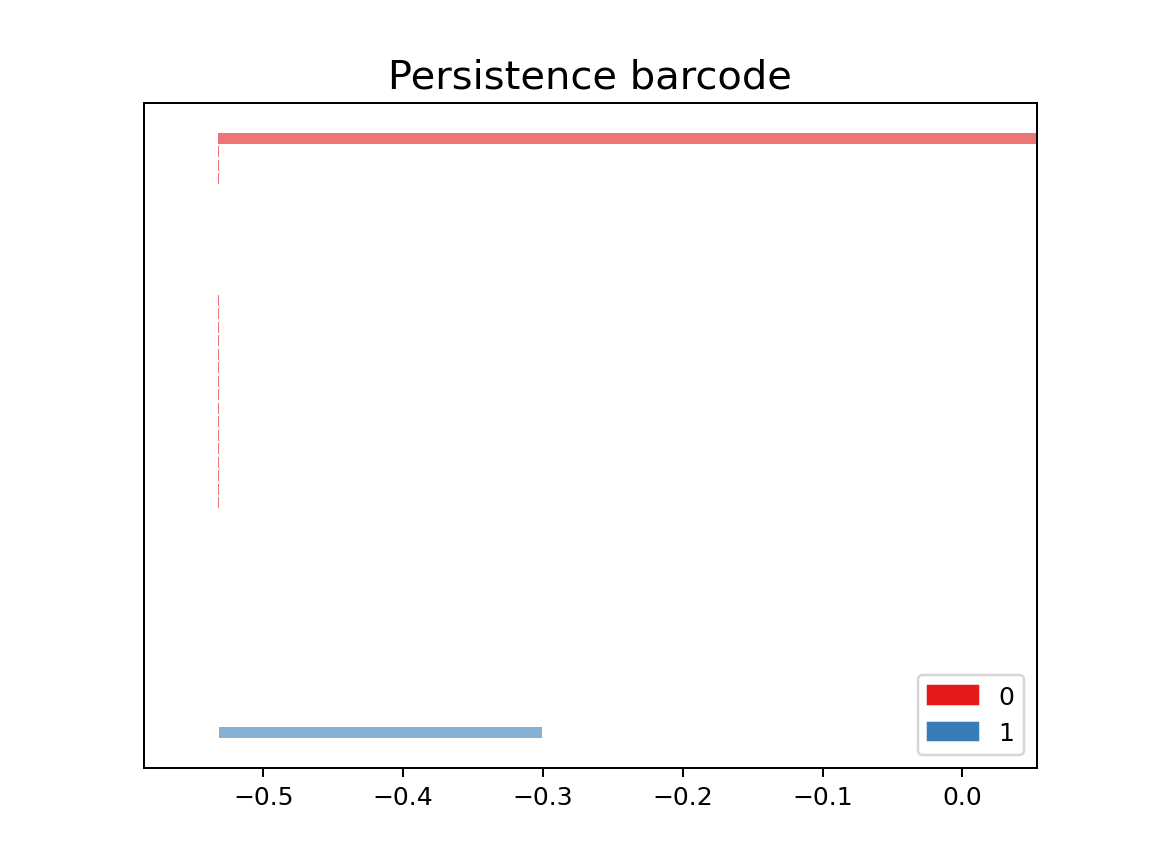

<IPython.core.display.Javascript object>


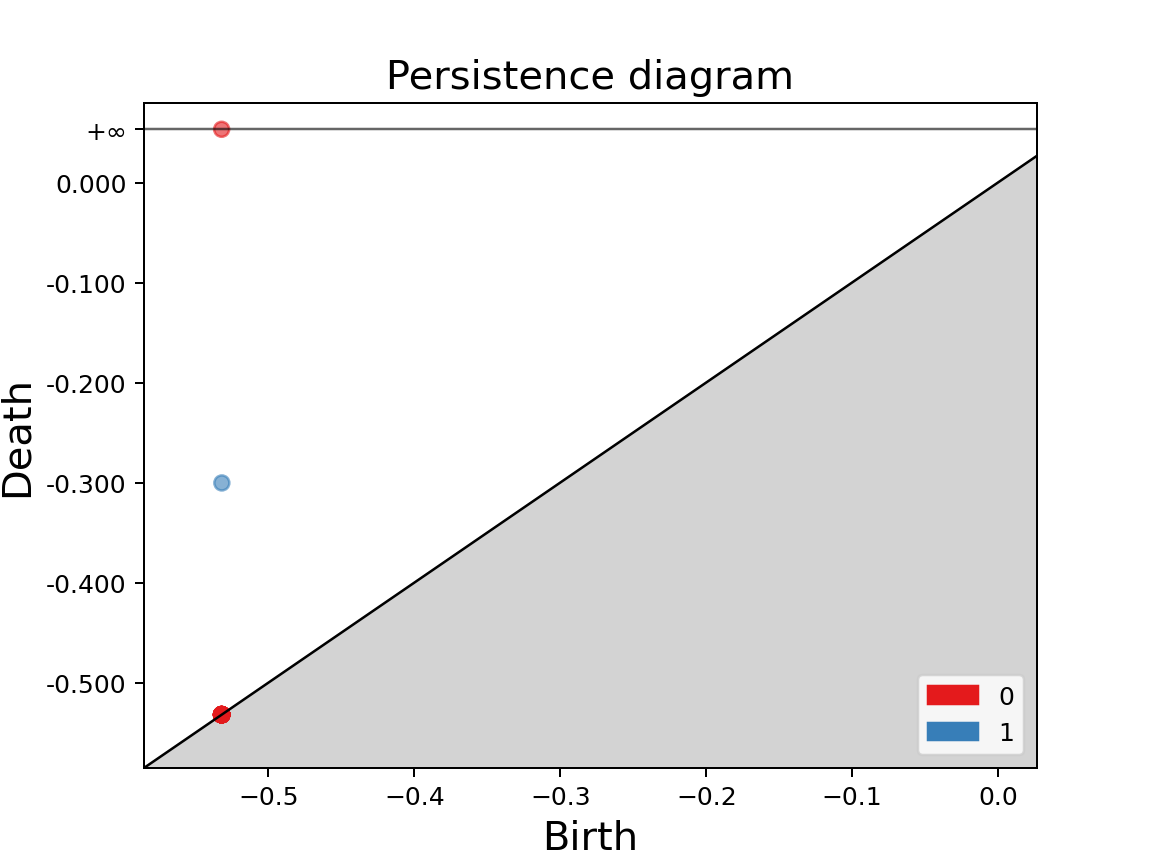

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

In [12]:
cplx2 = gd.CubicalComplex(top_dimensional_cells = -volcano)
diag = cplx2.persistence()
gd.plot_persistence_barcode(diag, legend=True)
gd.plot_persistence_diagram(diag, legend=True)

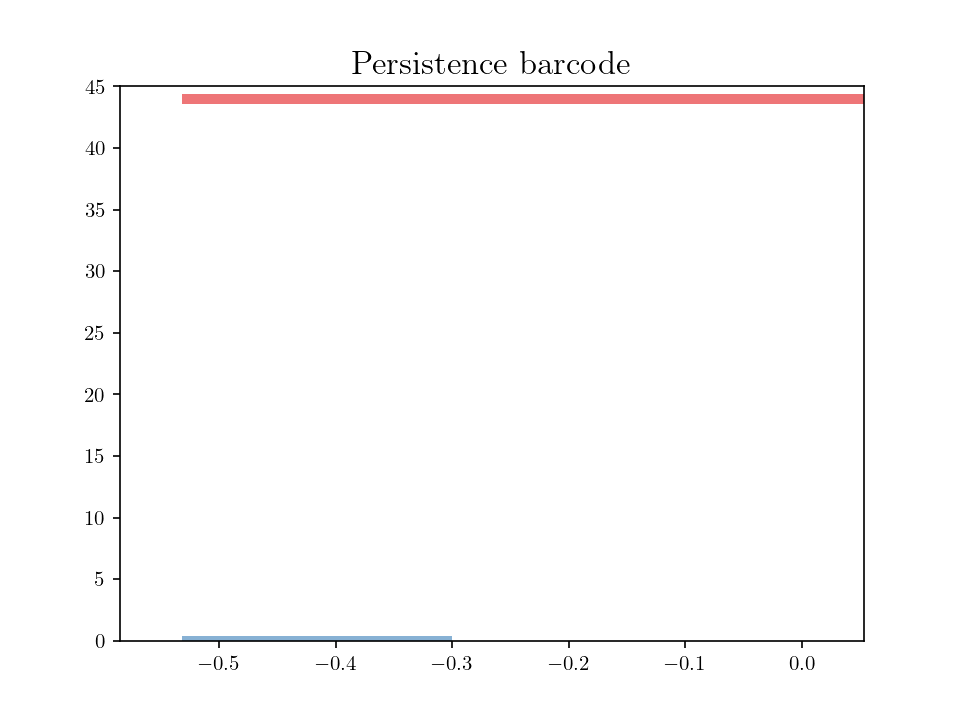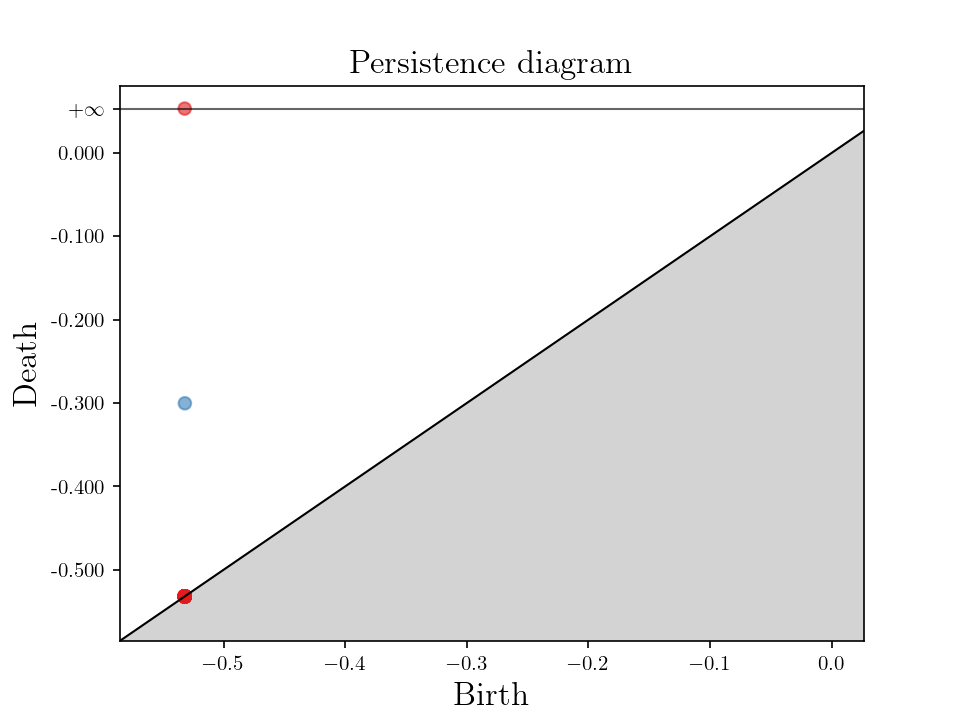

What happened to the point corresponding to the crater of the volcano between the sub- and super-levelsets?

#### 1d function

Let $f$ be the function $f: t \mapsto sin(t)+sin(2t)$

Build a table with 200 values of $f$ between 0 and $2\pi$. Plot the function, compute the persistence diagram of its sublevelsets, and draw its persistence diagram.

In [20]:
grid = np.linspace(0,2*np.pi,200)
gridx = grid[:,np.newaxis]
func = np.sin(gridx) + np.sin(gridx*2)
func.shape

(200, 1)

<IPython.core.display.Javascript object>


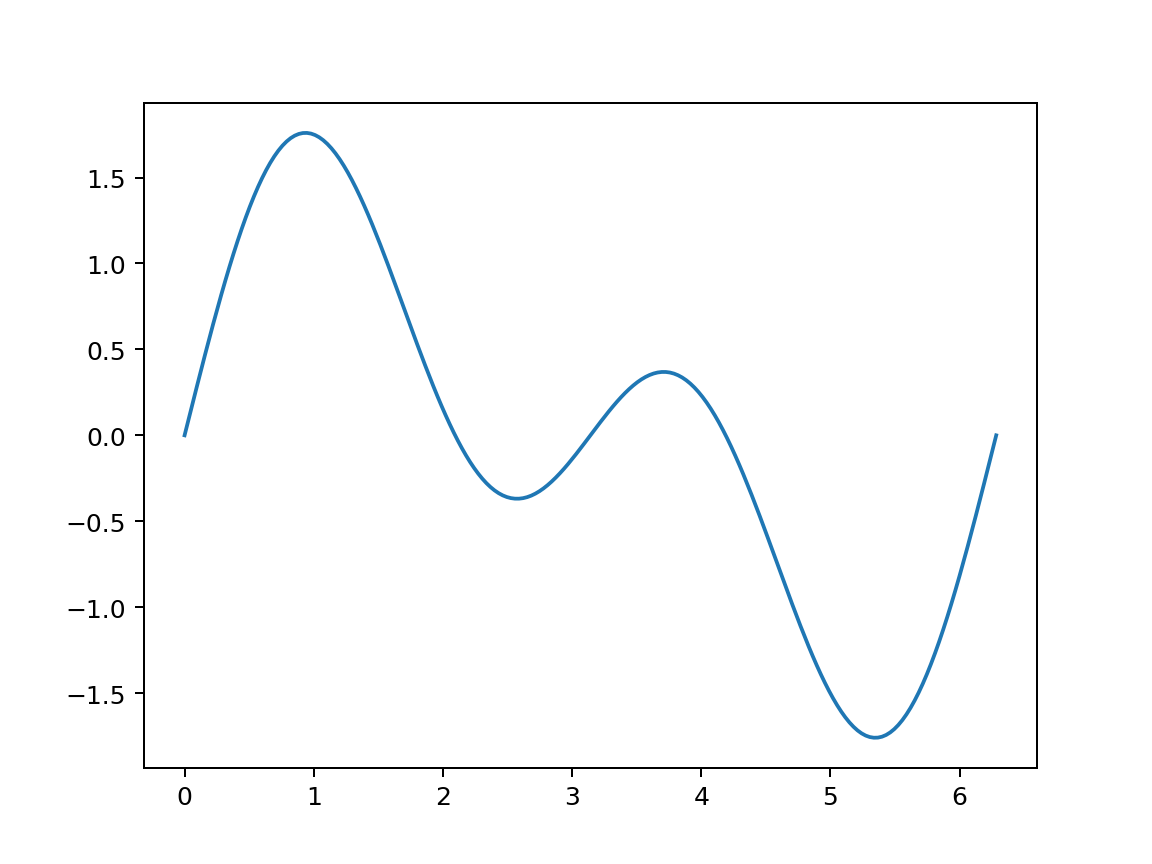

In [25]:
fig = plt.figure()
plt.plot(gridx,func)
plt.show()

<IPython.core.display.Javascript object>


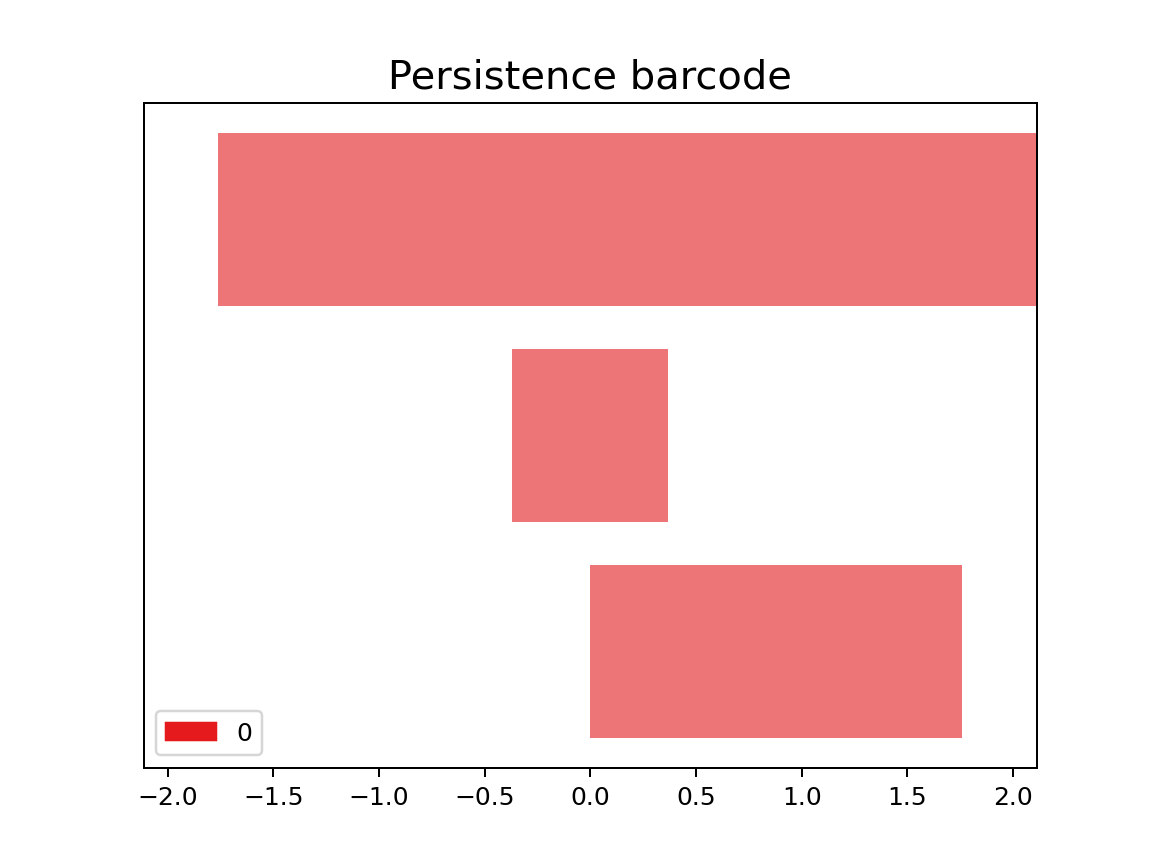

<IPython.core.display.Javascript object>


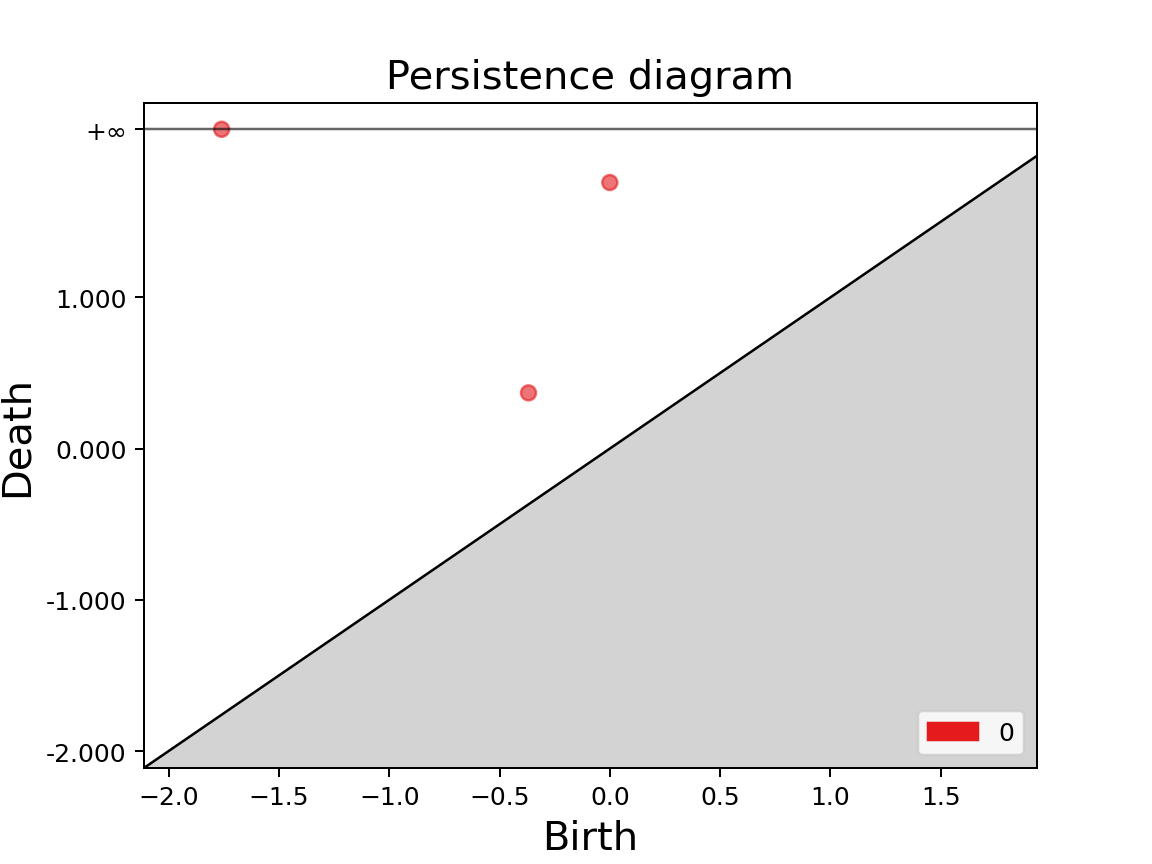

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

In [26]:
cplx = gd.CubicalComplex(top_dimensional_cells = func)
diag = cplx.persistence()
gd.plot_persistence_barcode(diag, legend=True)
gd.plot_persistence_diagram(diag, legend=True)

### 2. Point sets

Draw a set of points regularly spaced along a curve drawn on a torus. 

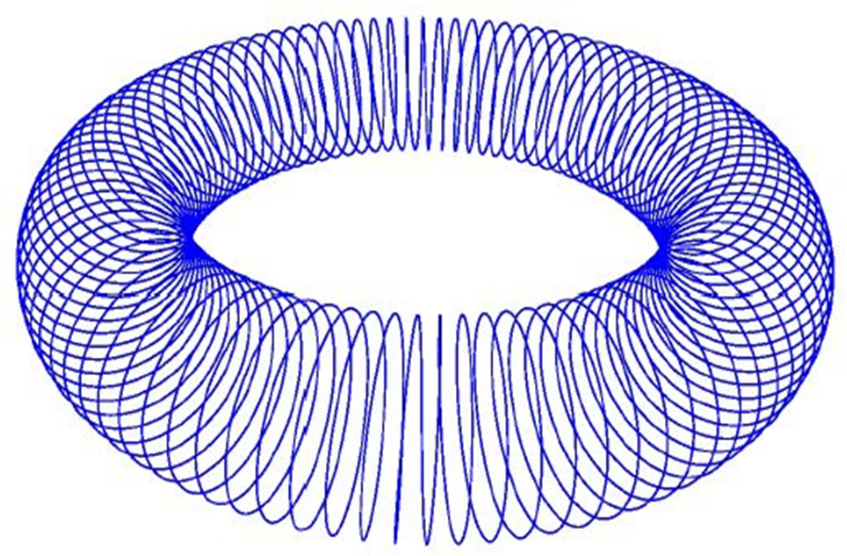

Here is a solution in $\mathbb{R}^4$.

<IPython.core.display.Javascript object>


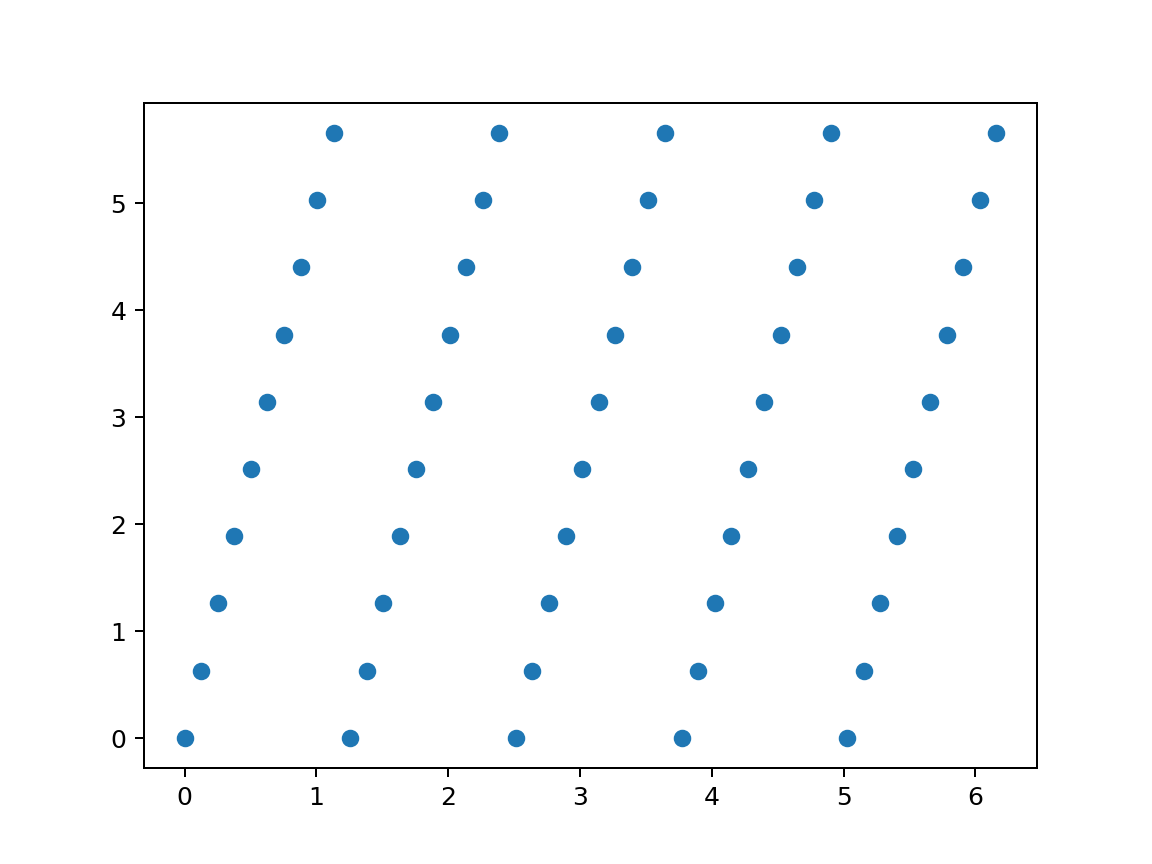

In [27]:
a = np.linspace(0, 2*np.pi, 50, False)
b = np.stack((np.cos(a),np.sin(a),np.cos(5*a),np.sin(5*a)),axis=-1)

# Plot the points on the unwrapped torus
plt.figure()
plt.scatter(a, 5*a % (2*np.pi))
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(a, b, volcano, cmap=matplotlib.cm.coolwarm)
plt.show()

Compute the persistence of the Čech filtration of these points. You can actually use an [$\alpha$-complex](https://gudhi.inria.fr/python/latest/alpha_complex_ref.html) for that. You should obtain the following plot.

<IPython.core.display.Javascript object>


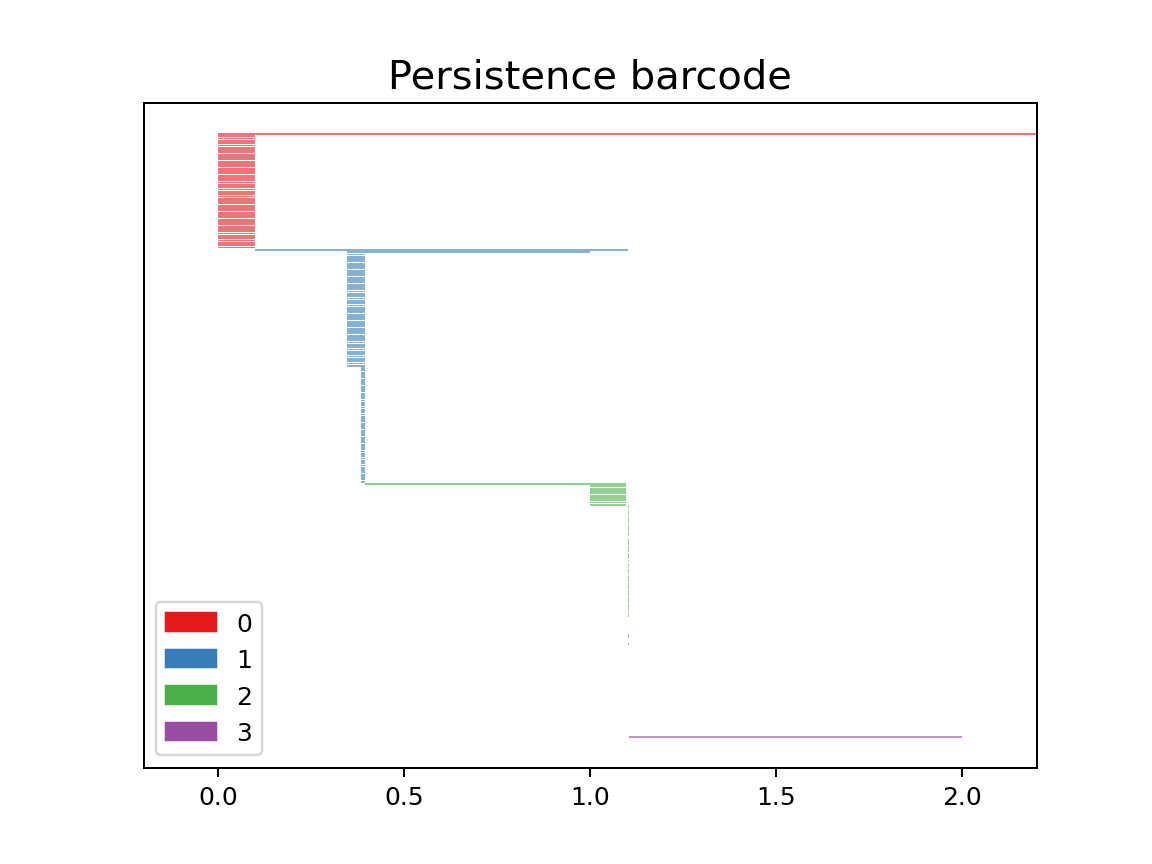

<IPython.core.display.Javascript object>


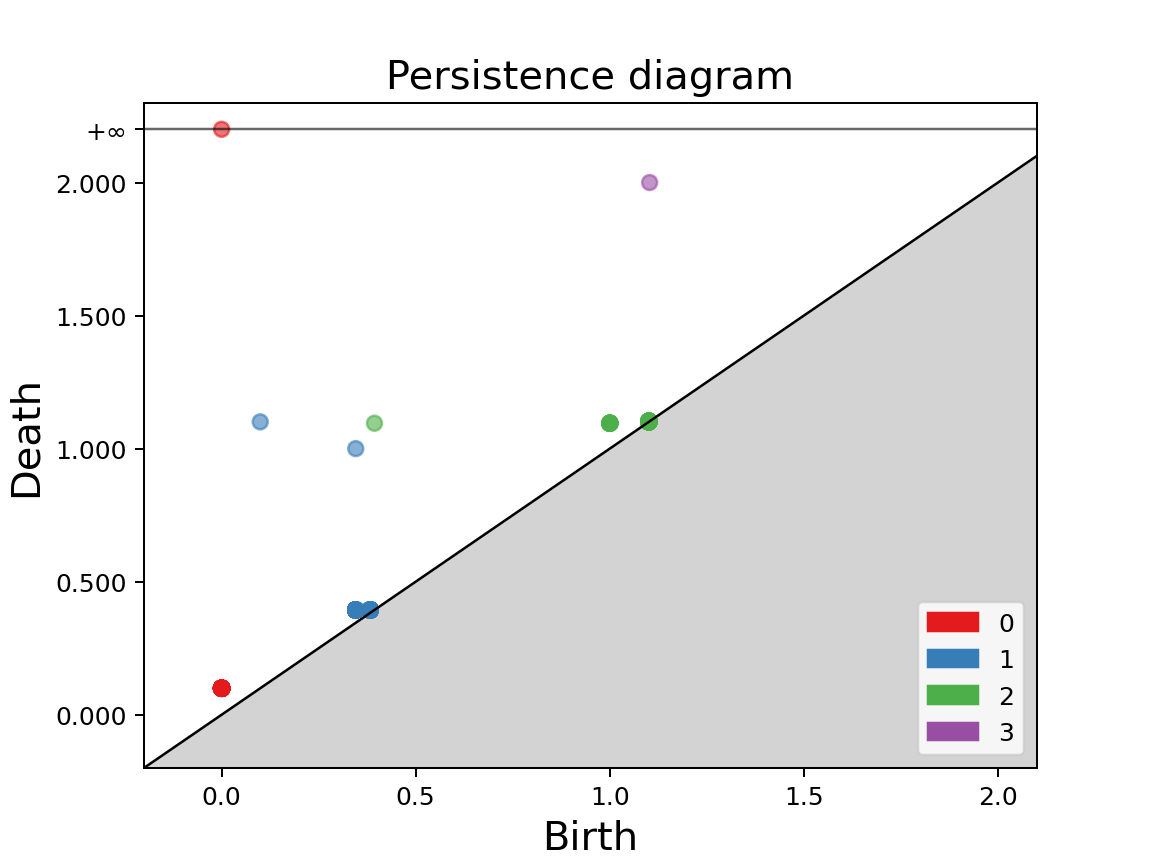

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

In [36]:
aplx = gd.AlphaComplex(points=b)
aplx_tree = aplx.create_simplex_tree()
diag = aplx_tree.persistence()
gd.plot_persistence_barcode(diag, legend=True)
gd.plot_persistence_diagram(diag, legend=True)

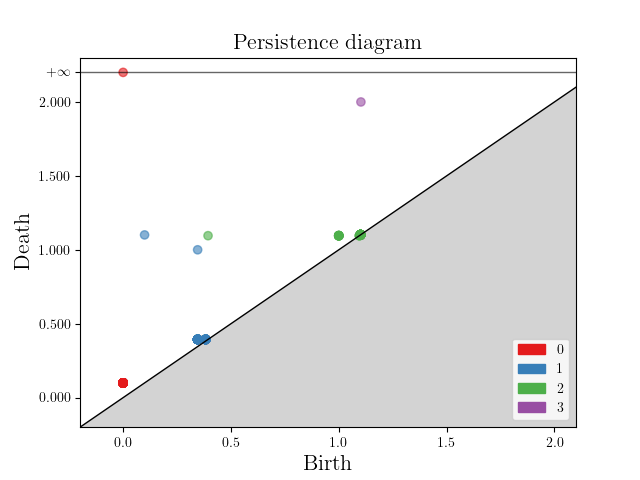

Can you recognize the features of a torus here? Is there anything extra?

Now do the same computation, but instead of using an $\alpha$-complex, approximate the Čech complex with a [Rips complex](https://gudhi.inria.fr/python/latest/rips_complex_ref.html). What happens if you only change the name of the class? While the $\alpha$-complex naturally has the ambient dimension, the Rips complex may be built up to an arbitrary dimension, so you need to specify a `max_dimension`. Can you still see the 3-sphere? What happens if you specify a larger dimension, say `max_dimension=5`?

### 3. Distance and stability

Let us consider again the point set on a curve on a torus in $\mathbb{R}^4$, and compute the persistence diagram of dimension 1 of its Rips filtration. Now perturb each point randomly by a small noise, and compute the persistence diagram of dimension 1 of these new points. Compute the [bottleneck distance](https://gudhi.inria.fr/python/latest/bottleneck_distance_user.html#gudhi.bottleneck_distance) between these diagrams. Retry it a few times, maybe also with dimension 0 or 2. Can you confirm the stability result?

Now do the same experiment with the $\alpha$-complex.

## 2. Application to time series

In this second part, we are going to apply persistence computations on time series data. The main motivation behind the use of persistence for time series is that several properties of time series can be encoded in a geometric point cloud and its associated Vietoris-Rips persistence diagram through the use of *time-delay embedding* (TDE). The definition of TDE is actually quite simple: given a time series $\{x(t_1),\dots,x(t_n)\}$, and (user-defined) dimension $d\in\mathbb N^*$ and delay $T\in \mathbb N^*$, one can generate a point cloud in $\mathbb R^{d+1}$ with:

$$\begin{bmatrix}
    x(t_1) & x(t_{1+T}) & \dots  & x(t_{1+dT}) \\ 
    x(t_2) & x(t_{2+T}) & \dots  & x(t_{2+dT}) \\ 
    \vdots & \vdots     & \vdots & \vdots \\
    x(t_m) & x(t_{m+T}) & \dots  & x(t_{m+dT}) \\ 
\end{bmatrix} \in \mathbb R^{m\times d+1}$$


where $ 1 \leq m \leq n-dT$. See figure below (taken from [this article](https://aip.scitation.org/doi/10.1063/1.1531823)).

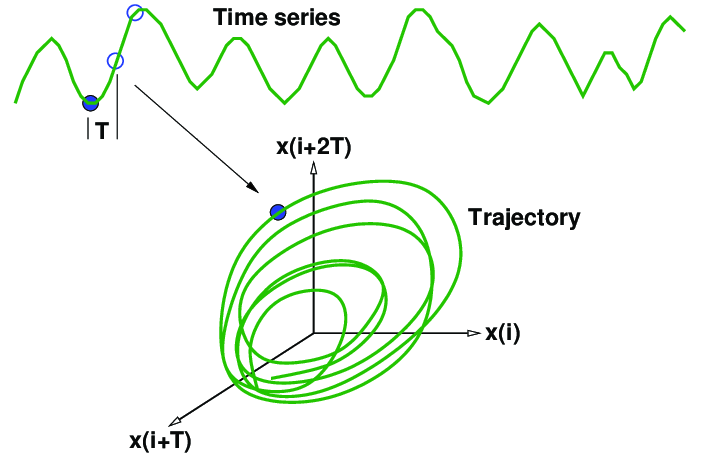

One of the very first observation is that periodicity in a time series directly translates into cycles in the associated point cloud. In order to check this, generate a simple periodic signal and visualize its TDE point cloud and Rips persistence diagram. For this, you can use the [TimeDelayEmbedding](https://gudhi.inria.fr/python/latest/point_cloud.html) function.

Another easy-to-detect time series property is shift, when the time series suddenly jumps from a range of values to another different range. Repeat the same experiment for such a phenomenon. 

Now let's get more practical ;-) In the following, we will retrieve times series corresponding to magnetometer data of a person undergoing through four different activities, and use the corresponding persistence diagrams to classify activities with a k-nearest neighbor classifier. The data can be downloaded [here](http://www-sop.inria.fr/abs/teaching/centrale-FGMDA/slides_mathieu/activities_detection.zip).

In [ ]:
path = 'activities_detection/'

In [ ]:
walking = np.load(path + 'walking_p1_left_leg.npy')
stepper = np.load(path + 'stepper_p1_left_leg.npy')
cross   = np.load(path + 'cross_training_p1_left_leg.npy')
jumping = np.load(path + 'jumping_p1_left_leg.npy')

Visualize the three time series (one of each spatial coordinate) of each activity.

Compute the four TDEs of the first spatial coordinate, randomly subsample these four point clouds 100 times to generate smaller point clouds (with only 100 points) in each activity, compute their persistence diagrams in dimension 1, and split them into train and test sets.

Use `gudhi` to compute the [bottleneck distance](https://gudhi.inria.fr/python/latest/bottleneck_distance_user.html) and different PD [representation](https://gudhi.inria.fr/python/latest/representations.html) matrices of the train and test sets. Make sure to set the parameters adequately. Representations and distance classes have API  similar to that of `Scikit-Learn`, with `fit` and `transform` methods.

Finally, train machine learning models on the train bottleneck distance and representations matrices, and evaluate it on your test data. How good is the accuracy score?